In [13]:
import pandas as pd
df = pd.read_csv("../data/data_for_modelling.csv")

In [14]:
df_sampled = df.sample(frac=0.1, random_state=42).reset_index(drop=True)
df_sampled

,visit_count,intake_type,intake_condition,animal_type,breed,color,outcome_type,HasName,age_days_intake,intake_month_num,intake_weekday_num,intake_hour,intactness,sex
0,1,Stray,Normal,Dog,Pug/Beagle,Tan/White,Adoption,0,180,6,0,13,intact,male
1,1,Stray,Normal,Cat,Domestic Shorthair Mix,Black/White,Adoption,0,60,10,3,12,intact,male
2,1,Stray,Sick,Cat,Domestic Shorthair,Flame Point,Adoption,1,60,7,4,12,intact,female
3,2,Owner Surrender,Normal,Dog,Australian Cattle Dog Mix,White/Brown,Transfer,1,2190,4,5,12,not_intact,female
4,1,Stray,Normal,Dog,Labrador Retriever,Black/White,Adoption,1,150,5,2,11,intact,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13516,1,Stray,Normal,Dog,Miniature Pinscher/Pug,Tricolor,Adoption,1,365,7,0,13,intact,female
13517,1,Stray,Normal,Cat,Domestic Shorthair Mix,Tortie,Transfer,1,30,6,1,10,intact,female
13518,1,Stray,Normal,Cat,Domestic Shorthair,Black,Adoption,1,30,7,1,16,not_intact,female
13519,1,Owner Surrender,Normal,Cat,Himalayan Mix,Tortie Point/White,Adoption,1,3650,2,6,10,not_intact,female


In [15]:
df_sampled.columns
print(df_sampled['outcome_type'].value_counts())

outcome_type
Adoption           6418
Transfer           4521
Return to Owner    1972
Euthanasia          452
Died                130
Other                28
Name: count, dtype: int64


In [16]:
data_for_modelling = df_sampled

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import fbeta_score
from sklearn.utils.class_weight import compute_class_weight
import pickle
from datetime import datetime

# ============================================================================
# CONFIGURATION
# ============================================================================

RANDOM_STATES = [1, 2, 3, 4, 5]
TRAIN_SIZE = 0.6
VAL_SIZE = 0.5

# XGBoost hyperparameters
N_ESTIMATORS = 10000  # Large value with early stopping
EARLY_STOPPING_ROUNDS = 50
LEARNING_RATE = 0.03  # Fixed

# Hyperparameters to tune
REG_ALPHA_VALUES = [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2]  # L1 regularization
REG_LAMBDA_VALUES = [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2]  # L2 regularization
MAX_DEPTH_VALUES = [1, 3, 5, 10, 20]

# Fixed hyperparameters
COLSAMPLE_BYTREE = 0.9  # Sample 90% of features per tree
SUBSAMPLE = 0.66  # Sample 66% of training data per iteration

print("="*80)
print("XGBOOST PIPELINE - ANIMAL SHELTER OUTCOME PREDICTION")
print("="*80)
print(f"\nConfiguration:")
print(f"  n_estimators: {N_ESTIMATORS} (with early_stopping_rounds={EARLY_STOPPING_ROUNDS})")
print(f"  learning_rate: {LEARNING_RATE} (fixed)")
print(f"  Random states: {RANDOM_STATES}")
print(f"  Train/Val/Test: {TRAIN_SIZE}/{(1-TRAIN_SIZE)*VAL_SIZE}/{(1-TRAIN_SIZE)*(1-VAL_SIZE)}")
print(f"\nHyperparameters to tune:")
print(f"  reg_alpha values: {REG_ALPHA_VALUES}")
print(f"  reg_lambda values: {REG_LAMBDA_VALUES}")
print(f"  max_depth values: {MAX_DEPTH_VALUES}")
print(f"\nFixed hyperparameters:")
print(f"  colsample_bytree: {COLSAMPLE_BYTREE}")
print(f"  subsample: {SUBSAMPLE}")
print(f"\nTotal combinations: {len(REG_ALPHA_VALUES)} × {len(REG_LAMBDA_VALUES)} × {len(MAX_DEPTH_VALUES)} = {len(REG_ALPHA_VALUES)*len(REG_LAMBDA_VALUES)*len(MAX_DEPTH_VALUES)}")

# ============================================================================
# PREPROCESSING FUNCTIONS
# ============================================================================

def encode_cyclical(X):
    """Transform cyclical features to sin/cos components."""
    if isinstance(X, pd.DataFrame):
        X = X.values
    
    periods = [12, 7, 24]
    result = []
    
    for i, period in enumerate(periods):
        values = X[:, i]
        result.append(np.sin(2 * np.pi * values / period).reshape(-1, 1))
        result.append(np.cos(2 * np.pi * values / period).reshape(-1, 1))
    
    return np.hstack(result)

def get_cyclical_feature_names(transformer, input_features):
    """Generate feature names for cyclical encoding output."""
    names = []
    for feature in input_features:
        names.append(f'{feature}_sin')
        names.append(f'{feature}_cos')
    return np.array(names)

def create_preprocessor():
    """Create preprocessing pipeline."""
    onehot_ftrs = [
        'intake_type', 'intake_condition', 'animal_type', 'sex', 
        'intactness', 'breed', 'color', 'HasName'
    ]
    
    std_ftrs = ['visit_count', 'age_days_intake']
    
    cyclical_ftrs = ['intake_month_num', 'intake_weekday_num', 'intake_hour']
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(
                sparse_output=False, 
                handle_unknown='ignore'
            ), onehot_ftrs),
            
            ('std', StandardScaler(), std_ftrs),
            
            ('cyclical', FunctionTransformer(
                encode_cyclical, 
                validate=False,
                feature_names_out=get_cyclical_feature_names
            ), cyclical_ftrs)
        ],
        verbose_feature_names_out=False
    )
    
    return preprocessor

def macro_f2_score(y_true, y_pred):
    """Calculate macro-averaged F2 score."""
    return fbeta_score(y_true, y_pred, beta=2, average='macro')

def calculate_baseline(y_train, y_val, y_test):
    """Calculate baseline F2 by predicting most frequent class."""
    most_frequent = y_train.value_counts().idxmax()
    
    y_train_pred = np.full(len(y_train), most_frequent)
    y_val_pred = np.full(len(y_val), most_frequent)
    y_test_pred = np.full(len(y_test), most_frequent)
    
    return {
        'most_frequent_class': most_frequent,
        'train_f2': macro_f2_score(y_train, y_train_pred),
        'val_f2': macro_f2_score(y_val, y_val_pred),
        'test_f2': macro_f2_score(y_test, y_test_pred),
    }

def compute_sample_weights(y_train):
    """
    Compute sample weights for imbalanced classes.
    XGBoost doesn't have class_weight='balanced', so we use sample_weight.
    """
    classes = np.unique(y_train)
    class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
    class_weight_dict = dict(zip(classes, class_weights))
    
    # Map class weights to sample weights
    sample_weights = np.array([class_weight_dict[y] for y in y_train])
    
    return sample_weights, class_weight_dict

# ============================================================================
# HYPERPARAMETER TUNING
# ============================================================================

def tune_hyperparameters(X_train_prep, y_train, X_val_prep, y_val, sample_weights, random_state):
    """
    Test all hyperparameter combinations for XGBoost.
    Tune reg_alpha, reg_lambda, and max_depth.
    Returns best model (already trained) and tuning results.
    """
    best_val_f2 = -np.inf
    best_model = None
    best_params = None
    
    tune_results = []
    
    total_combos = len(REG_ALPHA_VALUES) * len(REG_LAMBDA_VALUES) * len(MAX_DEPTH_VALUES)
    print(f"\n  Testing {total_combos} combinations...")
    
    combo_num = 0
    
    # Test all combinations of reg_alpha, reg_lambda, and max_depth
    for reg_alpha in REG_ALPHA_VALUES:
        for reg_lambda in REG_LAMBDA_VALUES:
            for max_depth in MAX_DEPTH_VALUES:
                combo_num += 1
                
                print(f"    [{combo_num}/{total_combos}] Testing α={reg_alpha:.2e}, λ={reg_lambda:.2e}, depth={max_depth}...", 
                      end='', flush=True)
                
                # Train XGBoost
                clf = XGBClassifier(
                    n_estimators=N_ESTIMATORS,
                    learning_rate=LEARNING_RATE,
                    max_depth=max_depth,
                    reg_alpha=reg_alpha,
                    reg_lambda=reg_lambda,
                    colsample_bytree=COLSAMPLE_BYTREE,
                    subsample=SUBSAMPLE,
                    random_state=random_state,
                    n_jobs=-1,
                    eval_metric='mlogloss',  # Multi-class log loss
                    early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                    verbosity=0  # Suppress XGBoost warnings
                )
                
                # Fit with early stopping
                clf.fit(
                    X_train_prep, y_train,
                    sample_weight=sample_weights,
                    eval_set=[(X_val_prep, y_val)],
                    verbose=False
                )
                
                # Evaluate
                y_train_pred = clf.predict(X_train_prep)
                y_val_pred = clf.predict(X_val_prep)
                
                train_f2 = macro_f2_score(y_train, y_train_pred)
                val_f2 = macro_f2_score(y_val, y_val_pred)
                
                # Get actual number of trees used (may be less than N_ESTIMATORS due to early stopping)
                n_trees_used = clf.best_iteration + 1 if hasattr(clf, 'best_iteration') else N_ESTIMATORS
                
                print(f" Train F2={train_f2:.4f}, Val F2={val_f2:.4f}, Trees={n_trees_used}", flush=True)
                
                # Store results
                tune_results.append({
                    'reg_alpha': reg_alpha,
                    'reg_lambda': reg_lambda,
                    'max_depth': max_depth,
                    'train_f2': train_f2,
                    'val_f2': val_f2,
                    'n_trees_used': n_trees_used,
                })
                
                # Track best model
                if val_f2 > best_val_f2:
                    best_val_f2 = val_f2
                    best_model = clf
                    best_params = {
                        'reg_alpha': reg_alpha,
                        'reg_lambda': reg_lambda,
                        'max_depth': max_depth,
                        'n_trees_used': n_trees_used
                    }
    
    print(f"\n  ✓ Best: α={best_params['reg_alpha']:.2e}, λ={best_params['reg_lambda']:.2e}, depth={best_params['max_depth']}, Val F2={best_val_f2:.4f}, Trees={best_params['n_trees_used']}")
    
    return best_model, best_params, tune_results

# ============================================================================
# MAIN EXPERIMENT
# ============================================================================

def run_experiment(data_for_modelling, random_state):
    """Run complete experiment for one random state."""
    
    print(f"\n{'='*80}")
    print(f"Random State: {random_state}")
    print(f"{'='*80}")
    
    # Separate features and target
    y = data_for_modelling['outcome_type']
    X = data_for_modelling.drop(columns=['outcome_type'])
    
    # Split data
    X_train, X_other, y_train, y_other = train_test_split(
        X, y, train_size=TRAIN_SIZE, stratify=y, random_state=random_state, shuffle=True
    )
    
    X_val, X_test, y_val, y_test = train_test_split(
        X_other, y_other, train_size=VAL_SIZE, stratify=y_other, random_state=random_state, shuffle=True
    )
    
    print(f"\nData splits: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")
    
    # Encode string labels to integers (XGBoost requires numeric labels)
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_val_encoded = label_encoder.transform(y_val)
    y_test_encoded = label_encoder.transform(y_test)
    
    print(f"\nLabel encoding:")
    for i, label in enumerate(label_encoder.classes_):
        print(f"  {i} ← {label}")
    
    # Calculate baseline (using encoded labels for consistency)
    baseline = calculate_baseline(pd.Series(y_train_encoded), pd.Series(y_val_encoded), pd.Series(y_test_encoded))
    
    # Get most frequent class name
    most_frequent_encoded = pd.Series(y_train_encoded).value_counts().idxmax()
    most_frequent_name = label_encoder.inverse_transform([most_frequent_encoded])[0]
    print(f"\nBaseline (predicting '{most_frequent_name}' [encoded as {most_frequent_encoded}]):")
    print(f"  Train F2: {baseline['train_f2']:.4f}")
    print(f"  Val F2:   {baseline['val_f2']:.4f}")
    print(f"  Test F2:  {baseline['test_f2']:.4f}")
    
    # Compute sample weights for class imbalance (using encoded labels)
    sample_weights, class_weight_dict = compute_sample_weights(pd.Series(y_train_encoded))
    
    print(f"\nClass distribution and weights (encoded):")
    for encoded_label in sorted(class_weight_dict.keys()):
        original_label = label_encoder.inverse_transform([encoded_label])[0]
        count = sum(y_train_encoded == encoded_label)
        pct = 100 * count / len(y_train_encoded)
        print(f"  {encoded_label} ({original_label:20s}): {count:4d} ({pct:5.1f}%), weight={class_weight_dict[encoded_label]:.4f}")
    
    # Preprocess
    preprocessor = create_preprocessor()
    preprocessor.fit(X_train)
    
    X_train_prep = preprocessor.transform(X_train)
    X_val_prep = preprocessor.transform(X_val)
    X_test_prep = preprocessor.transform(X_test)
    
    feature_names = preprocessor.get_feature_names_out()
    print(f"\nFeatures after preprocessing: {len(feature_names)}")
    
    # Tune hyperparameters (returns best model already trained)
    best_model, best_params, tune_results = tune_hyperparameters(
        X_train_prep, y_train_encoded, X_val_prep, y_val_encoded, sample_weights, random_state
    )
    
    # Get predictions from best model (no retraining) - returns encoded labels
    y_train_pred_encoded = best_model.predict(X_train_prep)
    y_val_pred_encoded = best_model.predict(X_val_prep)
    y_test_pred_encoded = best_model.predict(X_test_prep)
    
    # Calculate final scores (using encoded labels)
    train_f2 = macro_f2_score(y_train_encoded, y_train_pred_encoded)
    val_f2 = macro_f2_score(y_val_encoded, y_val_pred_encoded)
    test_f2 = macro_f2_score(y_test_encoded, y_test_pred_encoded)
    
    print(f"\nFinal Macro F2 Scores:")
    print(f"  Train: {train_f2:.4f} (baseline: {baseline['train_f2']:.4f}, Δ: +{train_f2-baseline['train_f2']:.4f})")
    print(f"  Val:   {val_f2:.4f} (baseline: {baseline['val_f2']:.4f}, Δ: +{val_f2-baseline['val_f2']:.4f})")
    print(f"  Test:  {test_f2:.4f} (baseline: {baseline['test_f2']:.4f}, Δ: +{test_f2-baseline['test_f2']:.4f})")
    
    # Decode predictions back to original labels for storage
    y_train_pred = label_encoder.inverse_transform(y_train_pred_encoded)
    y_val_pred = label_encoder.inverse_transform(y_val_pred_encoded)
    y_test_pred = label_encoder.inverse_transform(y_test_pred_encoded)
    
    print(f"\nFinal Macro F2 Scores:")
    print(f"  Train: {train_f2:.4f} (baseline: {baseline['train_f2']:.4f}, Δ: +{train_f2-baseline['train_f2']:.4f})")
    print(f"  Val:   {val_f2:.4f} (baseline: {baseline['val_f2']:.4f}, Δ: +{val_f2-baseline['val_f2']:.4f})")
    print(f"  Test:  {test_f2:.4f} (baseline: {baseline['test_f2']:.4f}, Δ: +{test_f2-baseline['test_f2']:.4f})")
    
    # Return results
    return {
        'random_state': random_state,
        'best_model': best_model,
        'preprocessor': preprocessor,
        'label_encoder': label_encoder,  # For decoding predictions
        'feature_names': feature_names,
        'class_weight_dict': class_weight_dict,
        'sample_weights': sample_weights,
        'best_params': best_params,
        'tune_results': tune_results,
        
        # Original data (string labels)
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test,
        
        # Encoded labels (for XGBoost compatibility)
        'y_train_encoded': y_train_encoded,
        'y_val_encoded': y_val_encoded,
        'y_test_encoded': y_test_encoded,
        
        # Preprocessed data
        'X_train_prep': X_train_prep,
        'X_val_prep': X_val_prep,
        'X_test_prep': X_test_prep,
        
        # Predictions (decoded back to strings)
        'y_train_pred': y_train_pred,
        'y_val_pred': y_val_pred,
        'y_test_pred': y_test_pred,
        
        # Scores
        'train_f2': train_f2,
        'val_f2': val_f2,
        'test_f2': test_f2,
        'baseline': baseline,
    }

# ============================================================================
# RUN ALL EXPERIMENTS
# ============================================================================

all_results = []

for rs in RANDOM_STATES:
    result = run_experiment(data_for_modelling, rs)
    all_results.append(result)

# ============================================================================
# AGGREGATE RESULTS
# ============================================================================

print("\n" + "="*80)
print("AGGREGATE RESULTS")
print("="*80)

test_f2_scores = [r['test_f2'] for r in all_results]

print(f"\nTest Macro F2 Scores:")
print(f"  Mean: {np.mean(test_f2_scores):.4f}")
print(f"  Std:  {np.std(test_f2_scores):.4f}")
print(f"  Min:  {np.min(test_f2_scores):.4f}")
print(f"  Max:  {np.max(test_f2_scores):.4f}")

baseline_test = np.mean([r['baseline']['test_f2'] for r in all_results])
print(f"\nBaseline Test F2: {baseline_test:.4f}")
print(f"Improvement: +{np.mean(test_f2_scores) - baseline_test:.4f}")

# Average number of trees used
avg_trees = np.mean([r['best_params']['n_trees_used'] for r in all_results])
print(f"\nAverage trees used (early stopping): {avg_trees:.0f} / {N_ESTIMATORS}")

XGBOOST PIPELINE - ANIMAL SHELTER OUTCOME PREDICTION

Configuration:
  n_estimators: 10000 (with early_stopping_rounds=50)
  learning_rate: 0.03 (fixed)
  Random states: [1, 2, 3, 4, 5]
  Train/Val/Test: 0.6/0.2/0.2

Hyperparameters to tune:
  reg_alpha values: [0.0, 0.01, 0.1, 1.0, 10.0, 100.0]
  reg_lambda values: [0.0, 0.01, 0.1, 1.0, 10.0, 100.0]
  max_depth values: [1, 3, 5, 10, 20]

Fixed hyperparameters:
  colsample_bytree: 0.9
  subsample: 0.66

Total combinations: 6 × 6 × 5 = 180

Random State: 1

Data splits: Train=8112, Val=2704, Test=2705

Label encoding:
  0 ← Adoption
  1 ← Died
  2 ← Euthanasia
  3 ← Other
  4 ← Return to Owner
  5 ← Transfer

Baseline (predicting 'Adoption' [encoded as 0]):
  Train F2: 0.1365
  Val F2:   0.1364
  Test F2:  0.1365

Class distribution and weights (encoded):
  0 (Adoption            ): 3851 ( 47.5%), weight=0.3511
  1 (Died                ):   78 (  1.0%), weight=17.3333
  2 (Euthanasia          ):  271 (  3.3%), weight=4.9889
  3 (Other  


CREATING PLOTS

Tune summary shape: (180, 6)
✓ Saved: ../figures/hyperparameter_plots_xgboost.png

BEST HYPERPARAMETERS

Best XGBoost (by avg validation F2):
  reg_alpha: 0.00e+00
  reg_lambda: 0.00e+00
  max_depth: 3.0
  Train F2: 0.7912
  Val F2: 0.3867
  Avg trees used: 2102


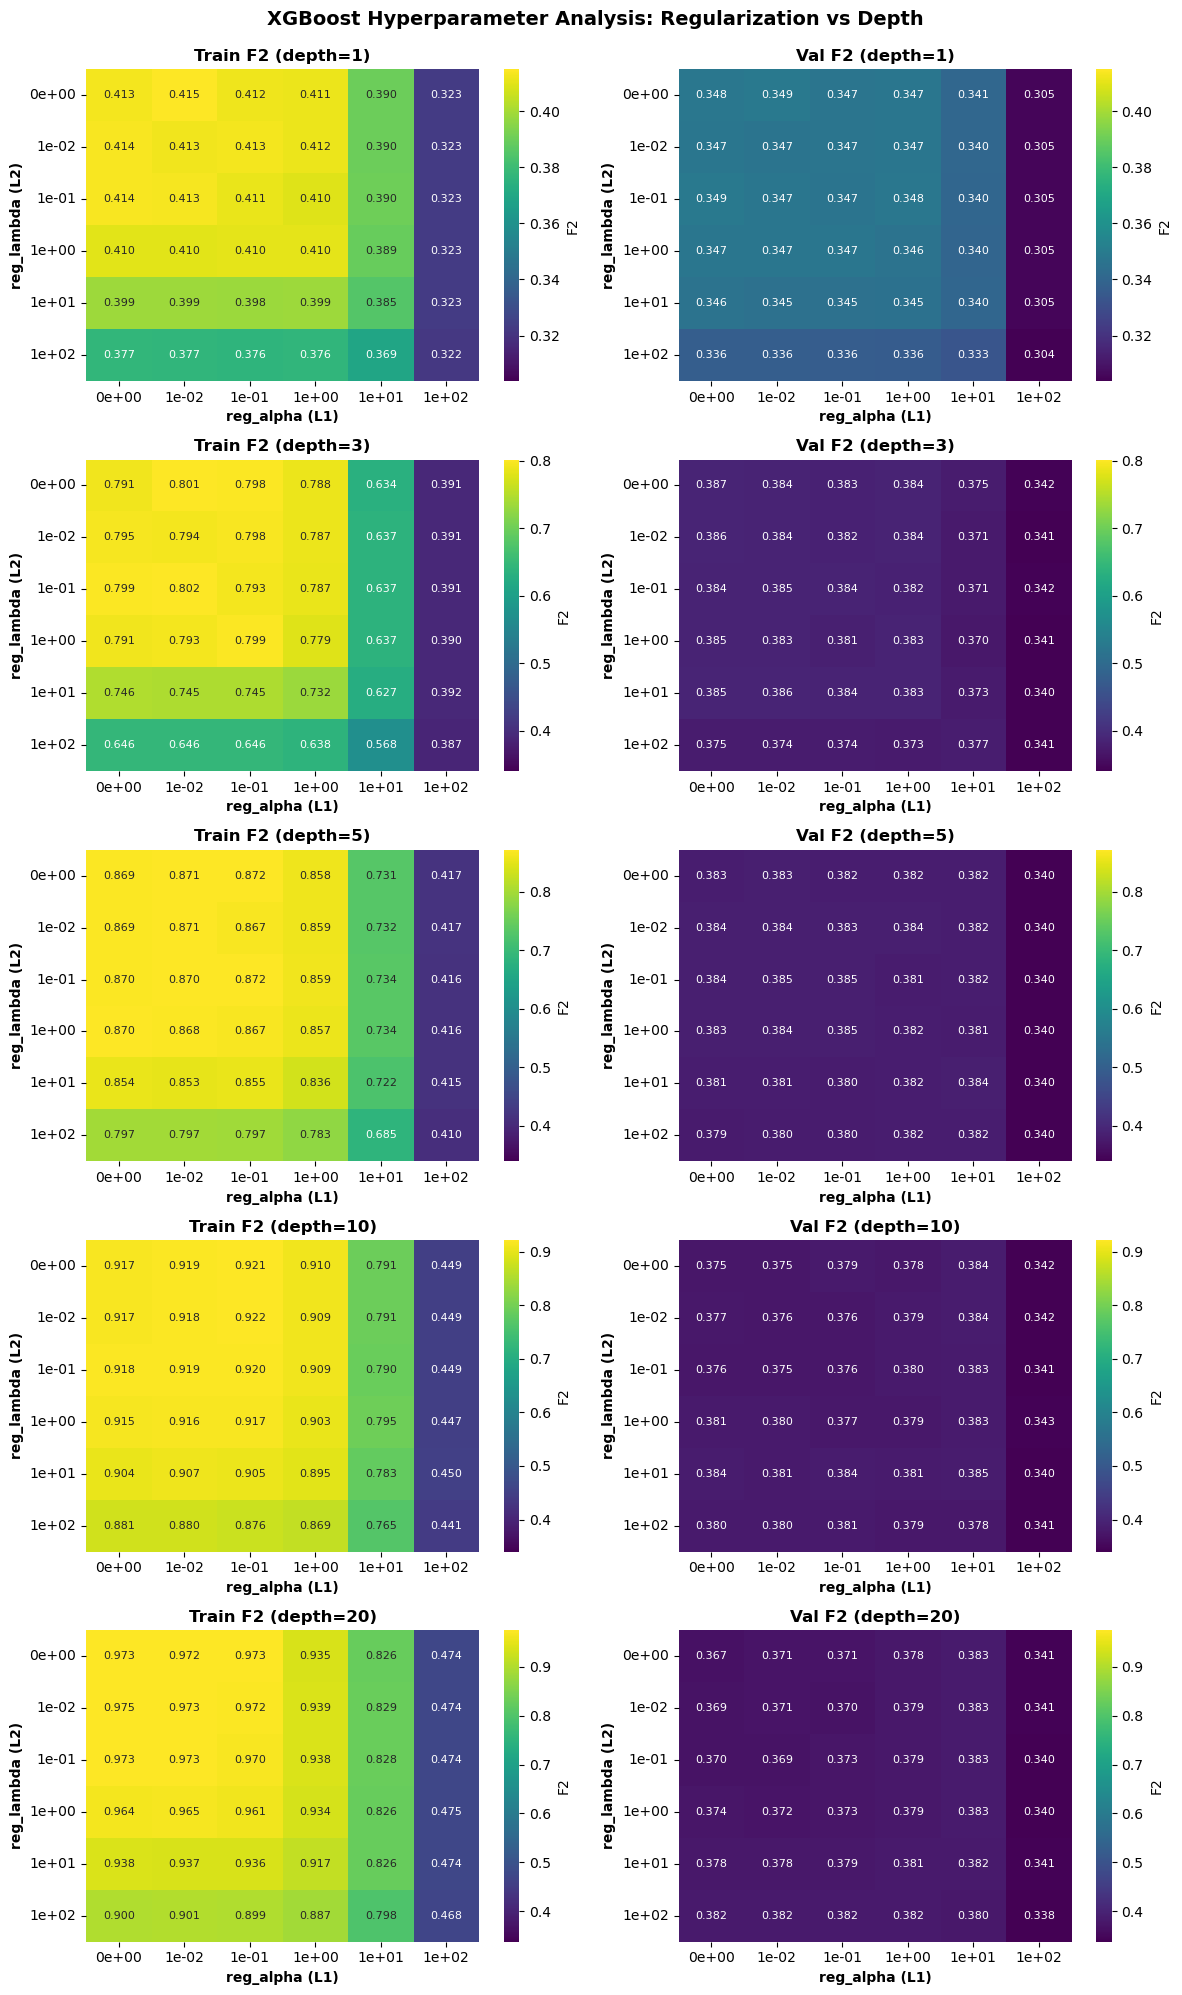

In [5]:
# ============================================================================
# CREATE PLOTS
# ============================================================================

print(f"\n{'='*80}")
print("CREATING PLOTS")
print(f"{'='*80}")

# Aggregate tuning results
all_tune_data = []
for result in all_results:
    for tune_result in result['tune_results']:
        all_tune_data.append(tune_result)

tune_df = pd.DataFrame(all_tune_data)

# Group by hyperparameters and calculate mean
tune_summary = tune_df.groupby(['reg_alpha', 'reg_lambda', 'max_depth']).agg({
    'train_f2': 'mean',
    'val_f2': 'mean',
    'n_trees_used': 'mean',
}).reset_index()

print(f"\nTune summary shape: {tune_summary.shape}")

# Create 5×2 grid: each row is one depth with train (left) and val (right)
fig, axes = plt.subplots(len(MAX_DEPTH_VALUES), 2, figsize=(12, 4*len(MAX_DEPTH_VALUES)))

for i, depth in enumerate(MAX_DEPTH_VALUES):
    # Filter for this depth
    depth_summary = tune_summary[tune_summary['max_depth'] == depth].copy()
    
    # Convert to strings for categorical ordering
    depth_summary['reg_alpha_str'] = depth_summary['reg_alpha'].apply(lambda x: f"{x:.0e}")
    depth_summary['reg_lambda_str'] = depth_summary['reg_lambda'].apply(lambda x: f"{x:.0e}")
    
    # Define ordering
    alpha_order = [f"{x:.0e}" for x in REG_ALPHA_VALUES]
    lambda_order = [f"{x:.0e}" for x in REG_LAMBDA_VALUES]
    
    # Convert to categorical
    depth_summary['reg_alpha_str'] = pd.Categorical(
        depth_summary['reg_alpha_str'], categories=alpha_order, ordered=True
    )
    depth_summary['reg_lambda_str'] = pd.Categorical(
        depth_summary['reg_lambda_str'], categories=lambda_order, ordered=True
    )
    
    # Create pivot tables
    train_pivot = depth_summary.pivot(index='reg_lambda_str', columns='reg_alpha_str', values='train_f2')
    val_pivot = depth_summary.pivot(index='reg_lambda_str', columns='reg_alpha_str', values='val_f2')
    
    # Determine common color scale for this depth
    vmin = min(train_pivot.min().min(), val_pivot.min().min())
    vmax = max(train_pivot.max().max(), val_pivot.max().max())
    
    # Plot training F2 (left column)
    ax_train = axes[i, 0]
    sns.heatmap(train_pivot, ax=ax_train, cmap='viridis', vmin=vmin, vmax=vmax,
                annot=True, fmt='.3f', cbar_kws={'label': 'F2'}, annot_kws={'size': 8})
    ax_train.set_title(f'Train F2 (depth={depth})', fontsize=12, fontweight='bold')
    ax_train.set_xlabel('reg_alpha (L1)', fontsize=10, fontweight='bold')
    ax_train.set_ylabel('reg_lambda (L2)', fontsize=10, fontweight='bold')
    
    # Plot validation F2 (right column)
    ax_val = axes[i, 1]
    sns.heatmap(val_pivot, ax=ax_val, cmap='viridis', vmin=vmin, vmax=vmax,
                annot=True, fmt='.3f', cbar_kws={'label': 'F2'}, annot_kws={'size': 8})
    ax_val.set_title(f'Val F2 (depth={depth})', fontsize=12, fontweight='bold')
    ax_val.set_xlabel('reg_alpha (L1)', fontsize=10, fontweight='bold')
    ax_val.set_ylabel('reg_lambda (L2)', fontsize=10, fontweight='bold')

plt.suptitle('XGBoost Hyperparameter Analysis: Regularization vs Depth', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../figures/hyperparameter_plots_xgboost.png', dpi=300, bbox_inches='tight')
print(f"✓ Saved: ../figures/hyperparameter_plots_xgboost.png")

# ============================
# BEST MODEL (by val F2)
# ============================
best_row = tune_summary.loc[tune_summary['val_f2'].idxmax()]
best_alpha = best_row['reg_alpha']
best_lambda = best_row['reg_lambda']
best_depth = best_row['max_depth']
best_val_f2 = best_row['val_f2']
best_train_f2 = best_row['train_f2']
best_trees = best_row['n_trees_used']

print("\n" + "="*80)
print("BEST HYPERPARAMETERS")
print("="*80)
print(f"\nBest XGBoost (by avg validation F2):")
print(f"  reg_alpha: {best_alpha:.2e}")
print(f"  reg_lambda: {best_lambda:.2e}")
print(f"  max_depth: {best_depth}")
print(f"  Train F2: {best_train_f2:.4f}")
print(f"  Val F2: {best_val_f2:.4f}")
print(f"  Avg trees used: {best_trees:.0f}")

In [ ]:
# ============================================================================
# SAVE RESULTS
# ============================================================================

print(f"\n{'='*80}")
print("SAVING RESULTS")
print(f"{'='*80}")

final_results = {
    'all_results': all_results,
    'config': {
        'model': 'XGBoost',
        'n_estimators': N_ESTIMATORS,
        'early_stopping_rounds': EARLY_STOPPING_ROUNDS,
        'learning_rate': LEARNING_RATE,
        'random_states': RANDOM_STATES,
        'reg_alpha_values': [f"{x:.0e}" for x in REG_ALPHA_VALUES],
        'reg_lambda_values': [f"{x:.0e}" for x in REG_LAMBDA_VALUES],
        'max_depth_values': [str(d) for d in MAX_DEPTH_VALUES],
        'colsample_bytree': COLSAMPLE_BYTREE,
        'subsample': SUBSAMPLE,
    },
    'test_scores': {
        'mean': np.mean(test_f2_scores),
        'std': np.std(test_f2_scores),
        'all': test_f2_scores,
    },
    'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

output_file = '../results/pipeline_results_xgboost.pkl'
with open(output_file, 'wb') as f:
    pickle.dump(final_results, f)

print(f"\n✓ Saved to: {output_file}")
print(f"\nSaved components:")
print(f"  • 5 best models (one per random state)")
print(f"  • Label encoder (for decoding predictions)")
print(f"  • All data splits (original and preprocessed)")
print(f"  • Both string and encoded labels")
print(f"  • Feature names")
print(f"  • All predictions (decoded to strings)")
print(f"  • Hyperparameter tuning results ({len(REG_ALPHA_VALUES)*len(REG_LAMBDA_VALUES)*len(MAX_DEPTH_VALUES)} combinations × 5 states)")
print(f"  • Sample weights and class weights")
print(f"  • Preprocessor objects")
print(f"  • Number of trees used (early stopping info)")

print(f"\n{'='*80}")
print("PIPELINE COMPLETE!")
print(f"{'='*80}")

In [8]:
best_row = tune_summary.loc[tune_summary['val_f2'].idxmax()]
print(best_row)

reg_alpha          0.00000
reg_lambda         0.00000
max_depth          3.00000
train_f2           0.79123
val_f2             0.38671
n_trees_used    2102.00000
Name: 1, dtype: float64


In [2]:
import pickle
import pandas as pd
import numpy as np

# ============================================================================
# LOAD SAVED XGBOOST RESULTS
# ============================================================================
output_file = '../results/pipeline_results_xgboost.pkl'

with open(output_file, 'rb') as f:
    final_results = pickle.load(f)

all_results = final_results['all_results']

# ============================================================================
# BUILD TUNING SUMMARY ACROSS RANDOM STATES
# ============================================================================
rows = []

for res in all_results:
    rs = res['random_state']
    for tr in res['tune_results']:
        rows.append({
            'random_state': rs,
            'reg_alpha': tr['reg_alpha'],
            'reg_lambda': tr['reg_lambda'],
            'max_depth': tr['max_depth'],
            'val_f2': tr['val_f2'],
        })

tune_df = pd.DataFrame(rows)

# Aggregate: mean & std of val_f2 for each (reg_alpha, reg_lambda, max_depth)
tune_summary = (
    tune_df
    .groupby(['reg_alpha', 'reg_lambda', 'max_depth'], as_index=False)
    .agg(
        mean_val_f2=('val_f2', 'mean'),
        std_val_f2=('val_f2', 'std'),
        n_runs=('val_f2', 'size')
    )
)

# ============================================================================
# FIND BEST HYPERPARAMETERS (BY MEAN VAL F2 ACROSS RUNS)
# ============================================================================
best_row = tune_summary.loc[tune_summary['mean_val_f2'].idxmax()]

print("Best XGBoost hyperparameters (by mean validation F2 across runs):")
print(f"  reg_alpha : {best_row['reg_alpha']}")
print(f"  reg_lambda: {best_row['reg_lambda']}")
print(f"  max_depth : {int(best_row['max_depth'])}")
print(f"  Mean Val F2 : {best_row['mean_val_f2']:.4f}")
print(f"  Std  Val F2 : {best_row['std_val_f2']:.4f}")
print(f"  Runs used   : {int(best_row['n_runs'])}")

print(
    f"\nValidation F2 (mean ± std): "
    f"{best_row['mean_val_f2']:.4f} ± {best_row['std_val_f2']:.4f}"
)


Best XGBoost hyperparameters (by mean validation F2 across runs):
  reg_alpha : 0.0
  reg_lambda: 0.0
  max_depth : 3
  Mean Val F2 : 0.3867
  Std  Val F2 : 0.0060
  Runs used   : 5

Validation F2 (mean ± std): 0.3867 ± 0.0060
